# Cholesky Experiment Results Visualization

This notebook visualizes the build metrics and runtime performance results from the cholesky decomposition experiment.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Load Data

In [16]:
# Load the CSV files
build_metrics = pd.read_csv('build_metrics.csv')
results = pd.read_csv('results.csv')

# Parse config_name to extract components for build_metrics
build_metrics[['matrix_size', 'num_blocks', 'scheduler']] = build_metrics['config_name'].str.split('_', expand=True)
build_metrics['matrix_size'] = build_metrics['matrix_size'].astype(int)
build_metrics['num_blocks'] = build_metrics['num_blocks'].astype(int)

# results.csv already has the columns split, no need to parse config_name

# Check available columns
has_compile_time = 'compile_time' in build_metrics.columns

print("Build Metrics:")
print(build_metrics.head())
print("\nBuild Metrics columns:", build_metrics.columns.tolist())
print(f"Has compile_time: {has_compile_time}")
print("\nRuntime Results:")
print(results.head())
print("\nRuntime Results columns:", results.columns.tolist())

Build Metrics:
           config_name  text_size  data_size  bss_size  total_size  \
0    2048_1_sequential       3448        144        40       36184   
1      2048_1_omp-task       3443        144        40       36080   
2  2048_1_virtual-fifo      16467       1376        48      729352   
3    2048_2_sequential       5145        144        40       41640   
4      2048_2_omp-task       4951        144        40       41024   

   matrix_size  num_blocks     scheduler  
0         2048           1    sequential  
1         2048           1      omp-task  
2         2048           1  virtual-fifo  
3         2048           2    sequential  
4         2048           2      omp-task  

Build Metrics columns: ['config_name', 'text_size', 'data_size', 'bss_size', 'total_size', 'matrix_size', 'num_blocks', 'scheduler']
Has compile_time: False

Runtime Results:
   matrix_size  num_blocks  block_size  block_memory   scheduler  wall_time  \
0         2048           1        2048      3355443

## Binary Size Analysis - Relative to Sequential (% Change)

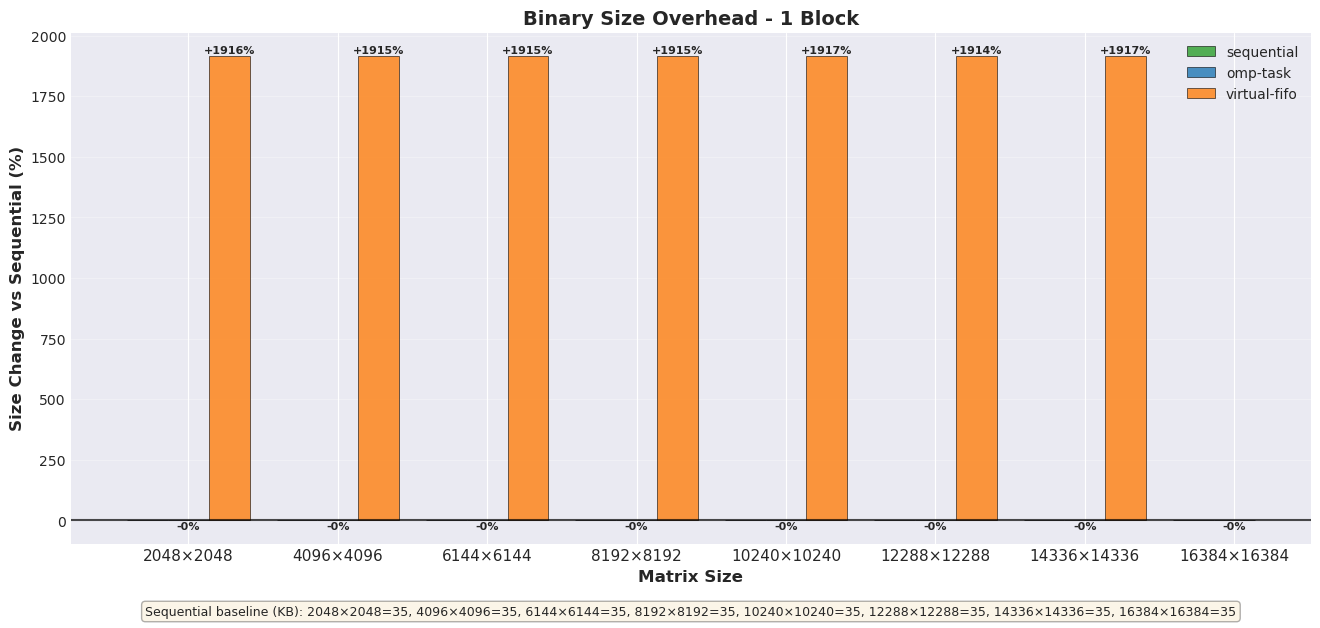

Saved: binary_size_overhead_1blocks.png


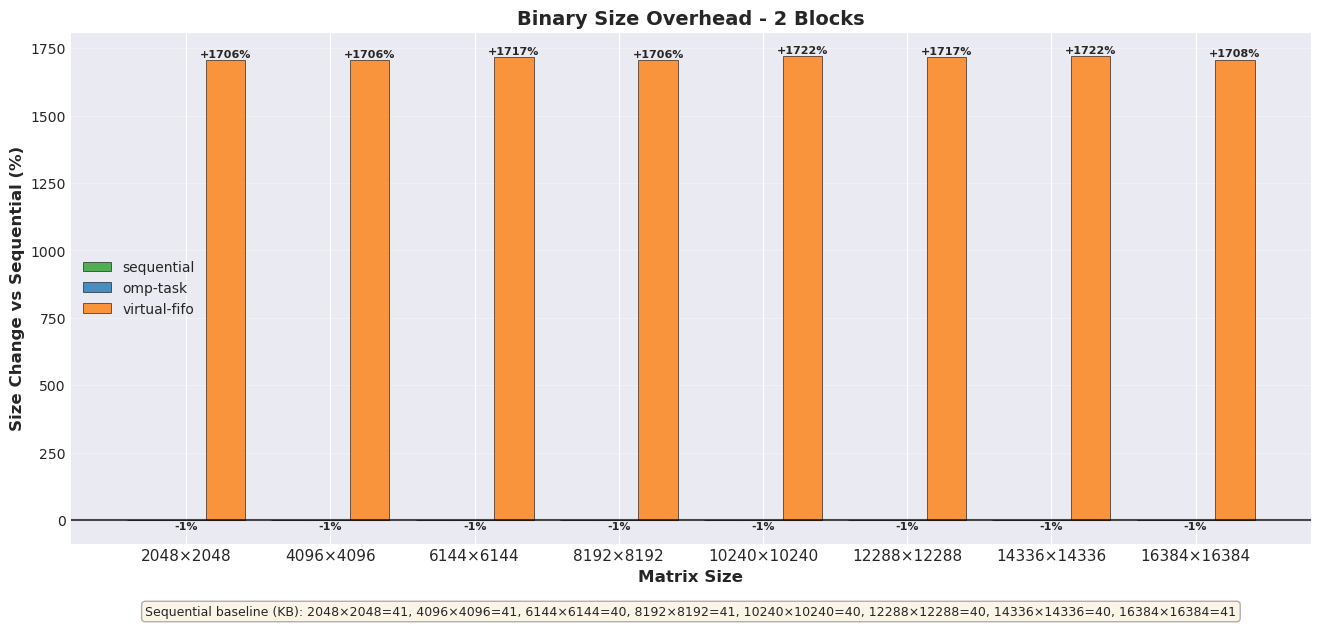

Saved: binary_size_overhead_2blocks.png


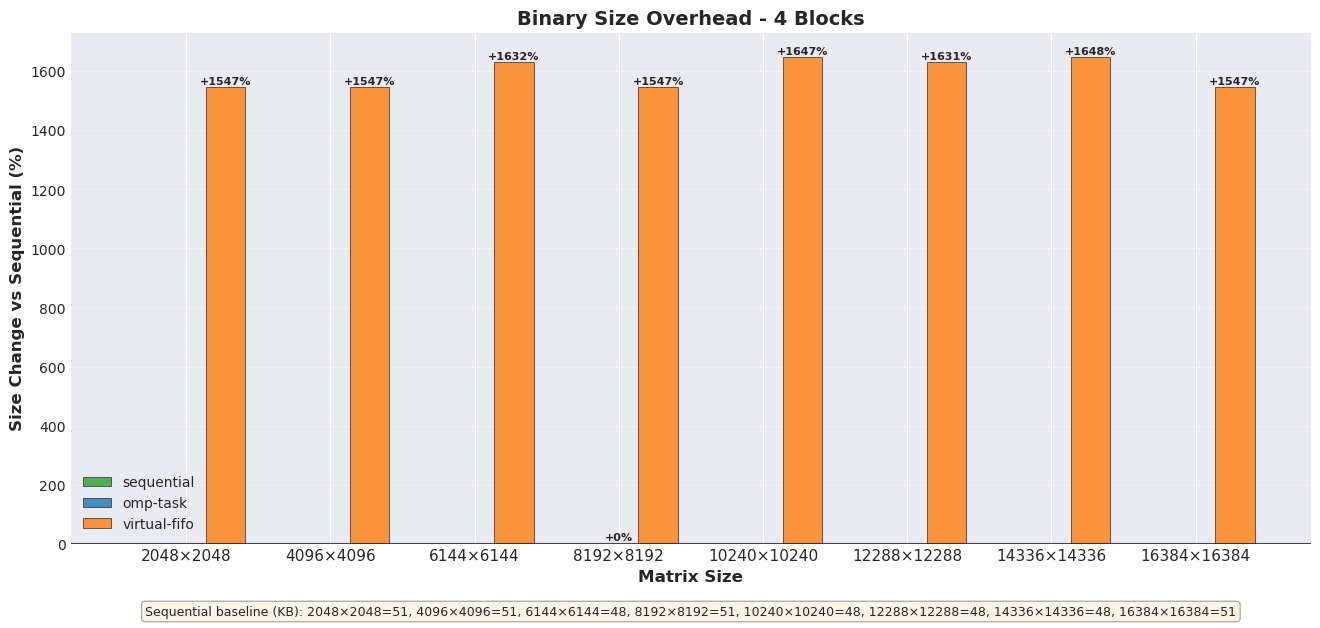

Saved: binary_size_overhead_4blocks.png


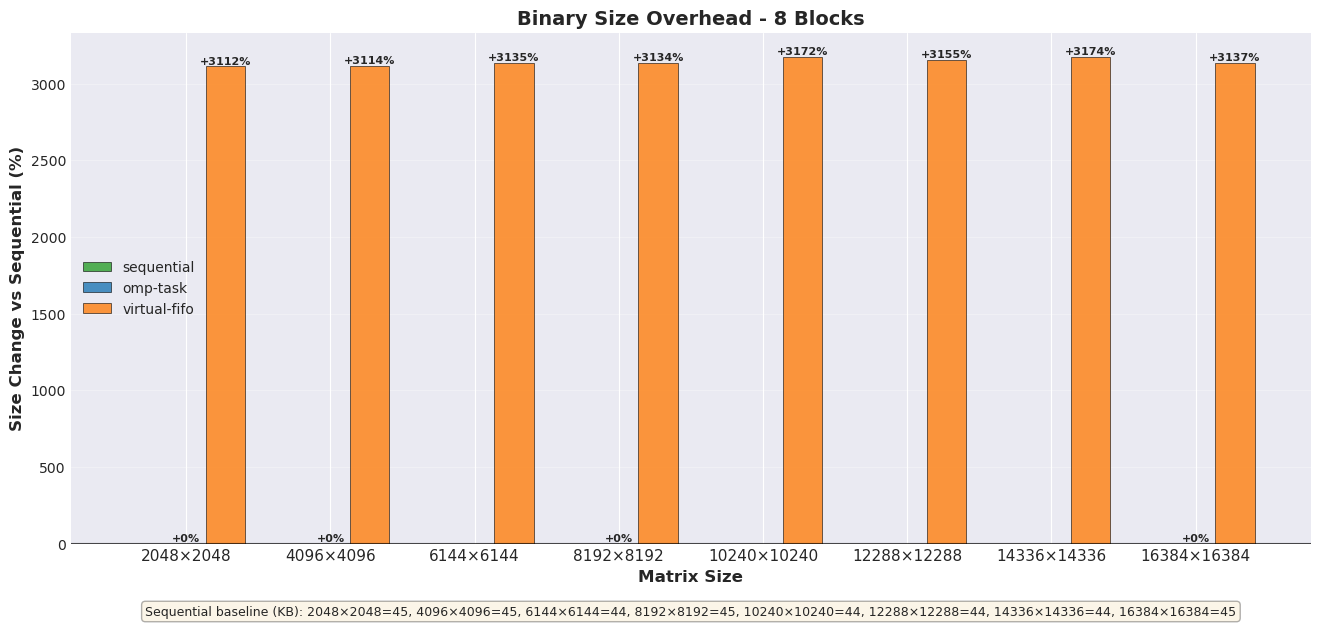

Saved: binary_size_overhead_8blocks.png


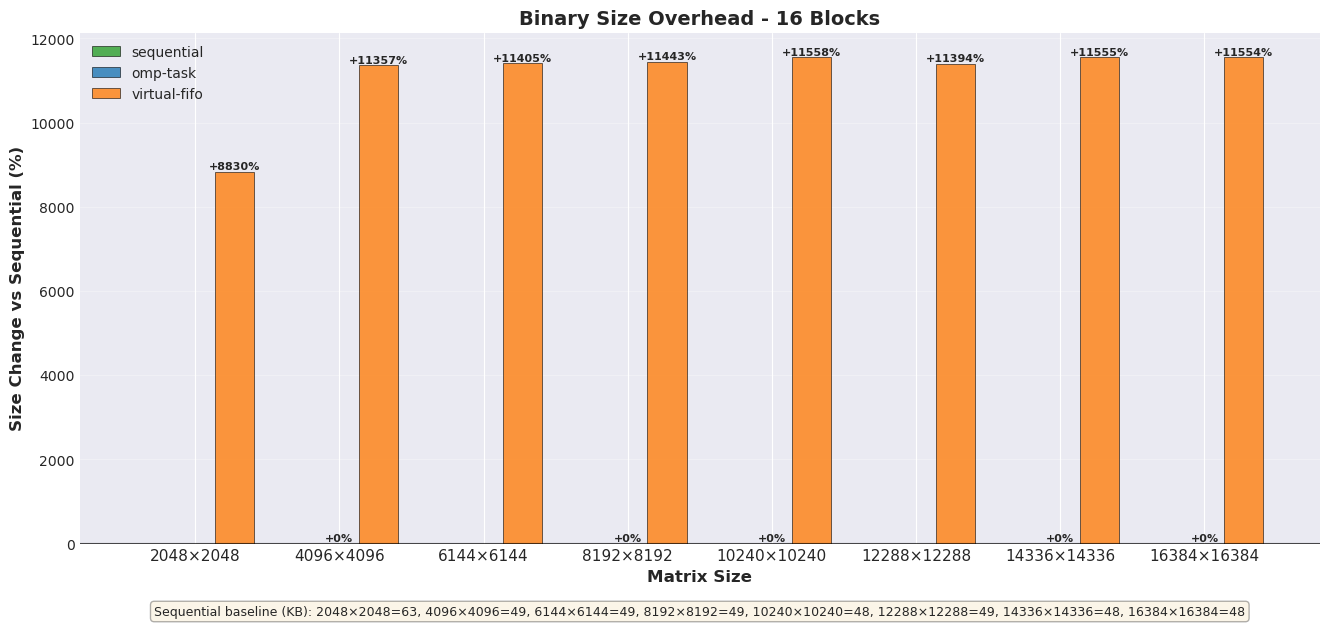

Saved: binary_size_overhead_16blocks.png


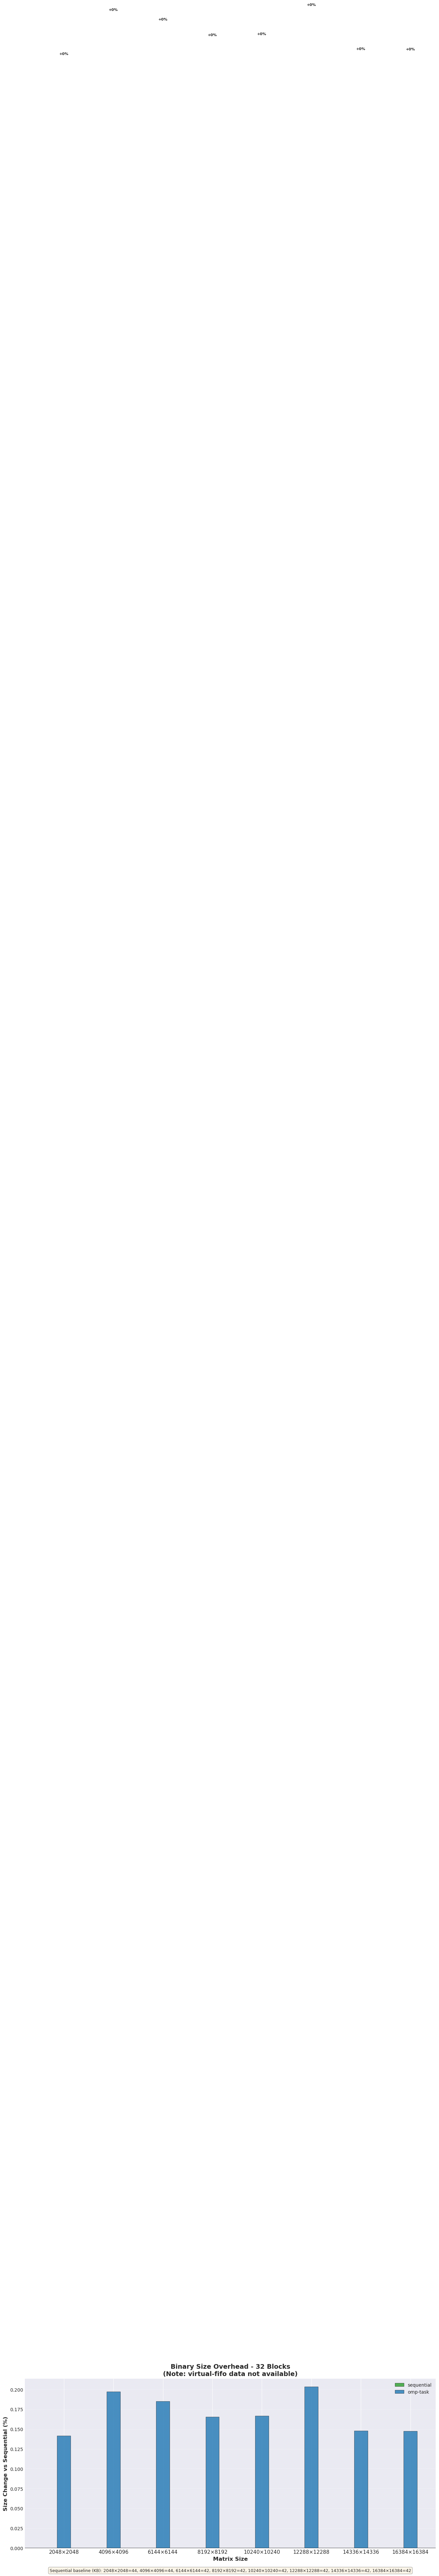

Saved: binary_size_overhead_32blocks.png


In [20]:
# Define scheduler order
scheduler_order = ['sequential', 'omp-task', 'virtual-fifo']

# Get unique number of blocks
num_blocks_list = sorted(build_metrics['num_blocks'].unique())

# Create one graph for each num_blocks configuration
for num_blocks in num_blocks_list:
    # Adjust figure size based on number of matrix sizes
    blocks_data = build_metrics[build_metrics['num_blocks'] == num_blocks].copy()
    matrix_sizes = sorted(blocks_data['matrix_size'].unique())
    num_groups = len(matrix_sizes)
    
    # Skip if no data
    if num_groups == 0:
        print(f"No data for {num_blocks} blocks, skipping...")
        continue
    
    # Set figure width: min 8, max 16, scale with number of groups
    fig_width = min(max(8, num_groups * 3), 16)
    fig, ax = plt.subplots(figsize=(fig_width, 7))
    
    # Calculate positions for grouped bars
    bar_width = 0.3
    group_width = len(scheduler_order) * bar_width + 0.2
    x_group_centers = np.arange(num_groups) * group_width
    
    # Track data for plotting
    scheduler_data = {sched: [] for sched in scheduler_order}
    sequential_values = []
    has_data = False
    schedulers_present = set()
    
    # For each matrix size configuration
    for matrix_size in matrix_sizes:
        # Get sequential baseline
        seq_data = blocks_data[
            (blocks_data['matrix_size'] == matrix_size) & 
            (blocks_data['scheduler'] == 'sequential')
        ]
        
        if len(seq_data) > 0:
            seq_size = seq_data.iloc[0]['total_size']
            sequential_values.append(seq_size / 1024)  # Store in KB for reference
            
            # For each scheduler
            for sched in scheduler_order:
                sched_data = blocks_data[
                    (blocks_data['matrix_size'] == matrix_size) & 
                    (blocks_data['scheduler'] == sched)
                ]
                
                if len(sched_data) > 0:
                    sched_size = sched_data.iloc[0]['total_size']
                    # Calculate percentage change relative to sequential
                    pct_change = ((sched_size - seq_size) / seq_size) * 100
                    scheduler_data[sched].append(pct_change)
                    has_data = True
                    schedulers_present.add(sched)
                else:
                    # Missing data for this scheduler - use NaN to skip plotting
                    scheduler_data[sched].append(np.nan)
        else:
            # No sequential baseline - skip this matrix size
            sequential_values.append(0)
            for sched in scheduler_order:
                scheduler_data[sched].append(np.nan)
    
    # Skip if no valid data
    if not has_data:
        print(f"No valid data for {num_blocks} blocks, skipping...")
        plt.close(fig)
        continue
    
    # Plot bars for each scheduler
    colors = {'sequential': '#2ca02c', 'omp-task': '#1f77b4', 'virtual-fifo': '#ff7f0e'}
    
    for sched_idx, sched in enumerate(scheduler_order):
        offset = (sched_idx - 1) * bar_width
        x_pos = x_group_centers + offset
        values = np.array(scheduler_data[sched])
        
        # Filter out NaN values for plotting
        valid_mask = ~np.isnan(values)
        if not valid_mask.any():
            continue  # Skip this scheduler if no valid data
        
        valid_x = x_pos[valid_mask]
        valid_values = values[valid_mask]
        
        bars = ax.bar(valid_x, valid_values, bar_width, label=sched, 
                     color=colors[sched], alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for xp, val in zip(valid_x, valid_values):
            if abs(val) > 0.1:  # Only show label if not essentially zero
                y_pos = val + (3 if val >= 0 else -3)
                va = 'bottom' if val >= 0 else 'top'
                ax.text(xp, y_pos, f'{val:+.0f}%', ha='center', va=va, fontsize=8, fontweight='bold')
    
    # Add reference line at 0%
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    
    # Customize the plot
    ax.set_ylabel('Size Change vs Sequential (%)', fontweight='bold', fontsize=12)
    
    # Add note if some schedulers are missing
    missing_schedulers = set(scheduler_order) - schedulers_present
    title = f'Binary Size Overhead - {num_blocks} Block{"s" if num_blocks > 1 else ""}'
    if missing_schedulers:
        title += f'\n(Note: {", ".join(sorted(missing_schedulers))} data not available)'
    ax.set_title(title, fontweight='bold', fontsize=14)
    
    ax.set_xticks(x_group_centers)
    ax.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes], fontsize=11)
    ax.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(loc='best', fontsize=10)
    
    # Add sequential baseline sizes as text below
    textstr = 'Sequential baseline (KB): ' + ', '.join([f'{ms}×{ms}={val:.0f}' 
                                                         for ms, val in zip(matrix_sizes, sequential_values) if val > 0])
    ax.text(0.5, -0.12, textstr, transform=ax.transAxes, fontsize=9, 
           verticalalignment='top', horizontalalignment='center',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Adjust layout with extra space at bottom for text box
    plt.subplots_adjust(bottom=0.15)
    filename = f'binary_size_overhead_{num_blocks}blocks.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

## Binary Size Comparison - Overall View

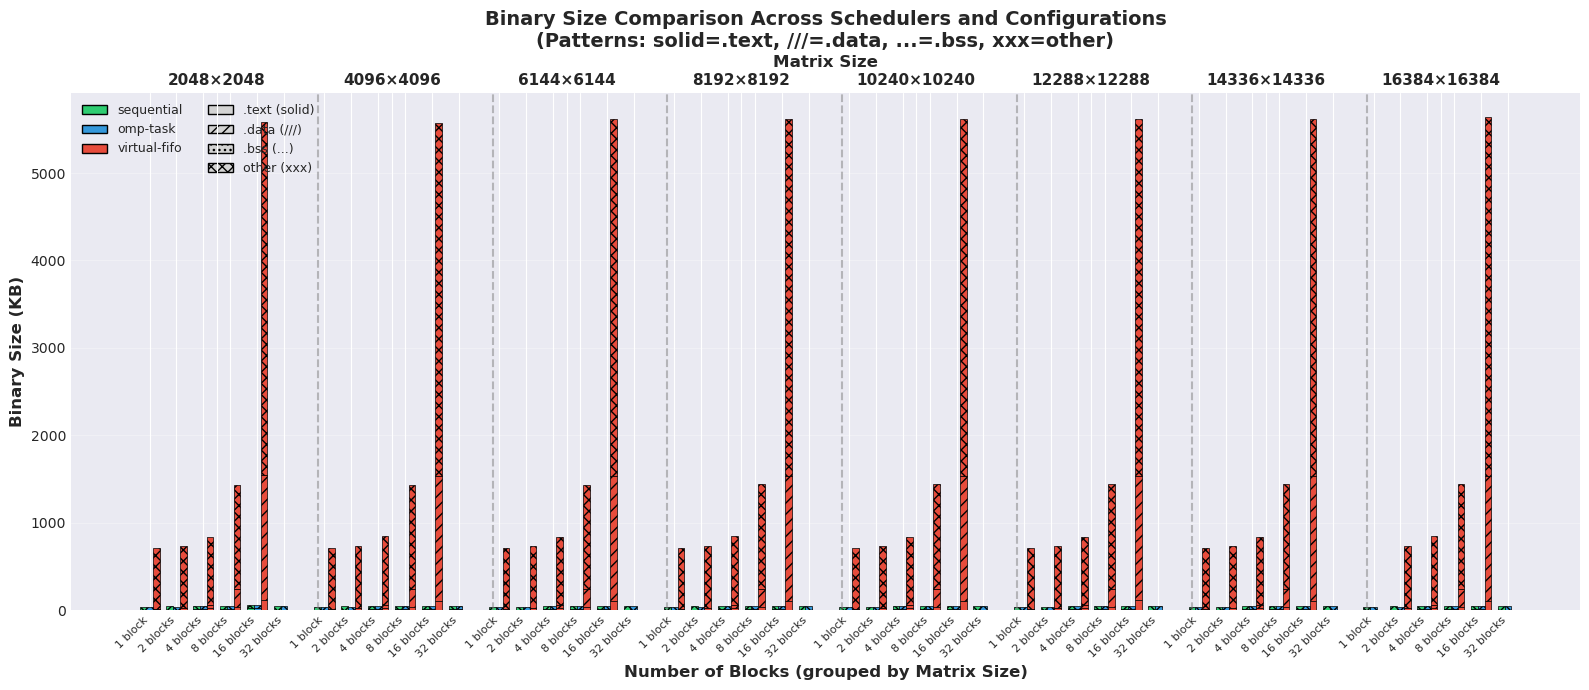

Saved: binary_size_grouped.png


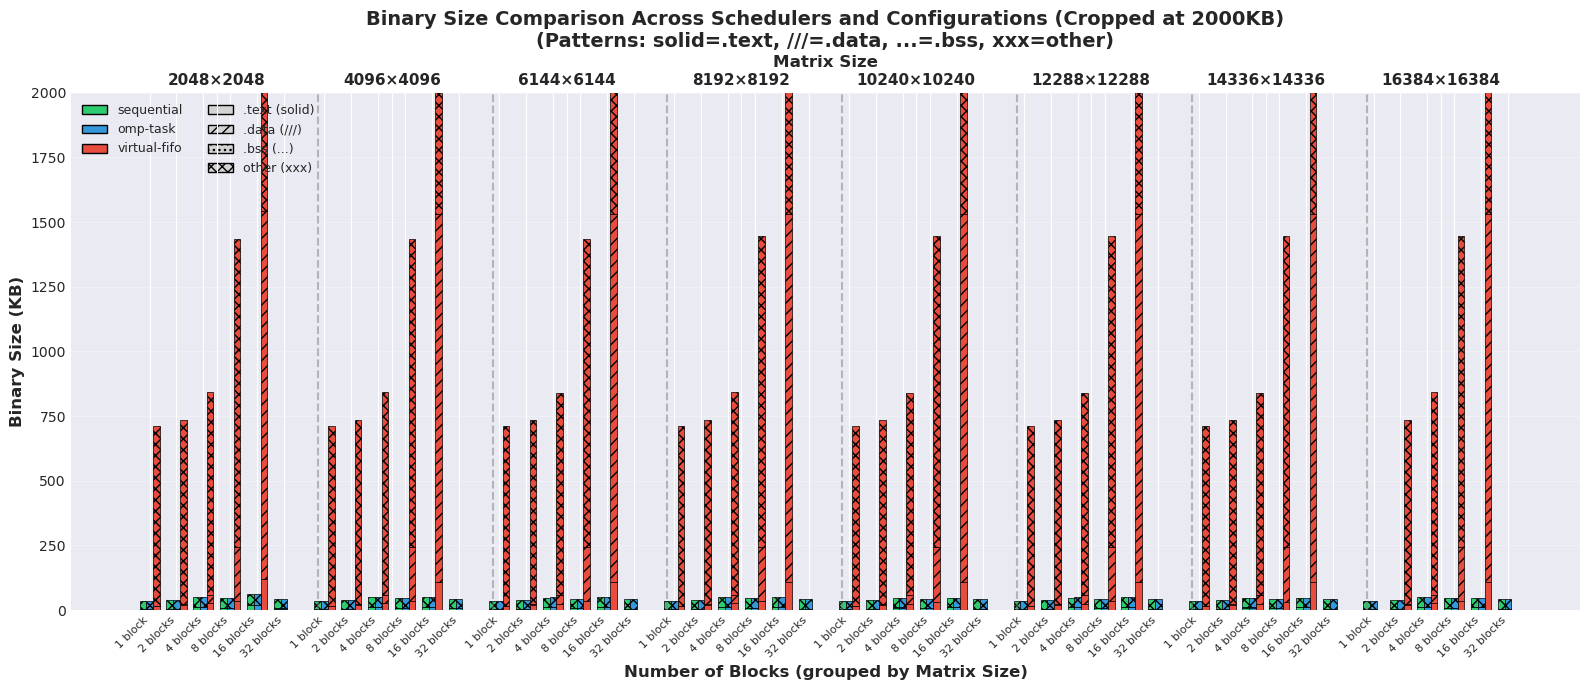

Saved: binary_size_grouped_cropped.png


In [29]:
# Overall binary size comparison by scheduler
# Sort by matrix_size first, then num_blocks (both numerically)
build_metrics_sorted = build_metrics.sort_values(['matrix_size', 'num_blocks'])

# Create hierarchical labels: matrix_size (primary), num_blocks (secondary)
build_metrics_sorted['config_label'] = build_metrics_sorted.apply(
    lambda x: f"{x['num_blocks']} block{'s' if x['num_blocks'] > 1 else ''}", 
    axis=1
)
build_metrics_sorted['matrix_label'] = build_metrics_sorted.apply(
    lambda x: f"{x['matrix_size']}×{x['matrix_size']}", 
    axis=1
)

# Pivot for easier plotting - using hierarchical index
pivot_text = build_metrics_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='text_size') / 1024
pivot_data = build_metrics_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='data_size') / 1024
pivot_bss = build_metrics_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='bss_size') / 1024
pivot_total = build_metrics_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='total_size') / 1024
pivot_other = pivot_total - pivot_text - pivot_data - pivot_bss

# Use scheduler_order from earlier
pivot_text = pivot_text[scheduler_order]
pivot_data = pivot_data[scheduler_order]
pivot_bss = pivot_bss[scheduler_order]
pivot_other = pivot_other[scheduler_order]

# Calculate positions with spacing between matrix size groups
matrix_sizes_numeric = sorted(pivot_text.index.get_level_values(0).unique())
x_positions = []
tick_positions = []
tick_labels = []
matrix_group_centers = []

current_x = 0
width = 0.25
group_spacing = 0.5  # Extra space between matrix size groups

for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    matrix_data = pivot_text.loc[matrix_size]
    num_configs = len(matrix_data)
    
    # Calculate center of this matrix group for label
    group_start = current_x
    
    for config_idx, num_blocks in enumerate(matrix_data.index):
        x_positions.append(current_x)
        tick_positions.append(current_x)
        tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        current_x += 1
    
    group_end = current_x - 1
    matrix_group_centers.append((group_start + group_end) / 2)
    
    # Add spacing before next matrix group
    current_x += group_spacing

x_positions = np.array(x_positions)

# Define distinct colors for each scheduler
scheduler_colors = {
    'sequential': '#2ecc71',    # Green
    'omp-task': '#3498db',      # Blue
    'virtual-fifo': '#e74c3c'   # Red
}

# Define hatching patterns for sections
section_hatches = {
    'text': '',        # Solid (no hatch)
    'data': '///',     # Diagonal lines
    'bss': '...',      # Dots
    'other': 'xxx'     # Cross-hatch
}

# Flatten the hierarchical data for plotting
flat_text = pivot_text.values
flat_data = pivot_data.values
flat_bss = pivot_bss.values
flat_other = pivot_other.values

# Function to create the binary size plot
def plot_binary_size_comparison(ylim=None, filename='binary_size_grouped.png'):
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # Plot grouped bars for each scheduler
    for i, scheduler in enumerate(scheduler_order):
        offset = (i - 1) * width
        color = scheduler_colors.get(scheduler, f'C{i}')
        
        # Plot each section with different hatching
        p1 = ax.bar(x_positions + offset, flat_text[:, i], width, 
                    label=f'{scheduler}', color=color, 
                    hatch=section_hatches['text'], edgecolor='black', linewidth=0.5)
        p2 = ax.bar(x_positions + offset, flat_data[:, i], width, 
                    bottom=flat_text[:, i], color=color,
                    hatch=section_hatches['data'], edgecolor='black', linewidth=0.5)
        p3 = ax.bar(x_positions + offset, flat_bss[:, i], width, 
                    bottom=flat_text[:, i]+flat_data[:, i], color=color,
                    hatch=section_hatches['bss'], edgecolor='black', linewidth=0.5)
        p4 = ax.bar(x_positions + offset, flat_other[:, i], width, 
                    bottom=flat_text[:, i]+flat_data[:, i]+flat_bss[:, i], 
                    color=color, hatch=section_hatches['other'], edgecolor='black', linewidth=0.5)
    
    # Add vertical separators between matrix size groups
    current_x = 0
    for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
        if matrix_idx > 0:
            separator_x = current_x - group_spacing / 2
            ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
        
        matrix_data = pivot_text.loc[matrix_size]
        current_x += len(matrix_data) + group_spacing
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = []
    
    # Add scheduler colors
    for scheduler in scheduler_order:
        legend_elements.append(Patch(facecolor=scheduler_colors.get(scheduler, 'gray'), 
                                     edgecolor='black', label=scheduler))
    
    # Add a separator
    legend_elements.append(Patch(facecolor='none', edgecolor='none', label=''))
    
    # Add section patterns
    legend_elements.extend([
        Patch(facecolor='lightgray', edgecolor='black', hatch='', label='.text (solid)'),
        Patch(facecolor='lightgray', edgecolor='black', hatch='///', label='.data (///)'),
        Patch(facecolor='lightgray', edgecolor='black', hatch='...', label='.bss (...)'),
        Patch(facecolor='lightgray', edgecolor='black', hatch='xxx', label='other (xxx)')
    ])
    
    # Set y-axis limit if specified
    if ylim is not None:
        ax.set_ylim(0, ylim)
        title = f'Binary Size Comparison Across Schedulers and Configurations (Cropped at {ylim}KB)\n(Patterns: solid=.text, ///=.data, ...=.bss, xxx=other)'
    else:
        title = 'Binary Size Comparison Across Schedulers and Configurations\n(Patterns: solid=.text, ///=.data, ...=.bss, xxx=other)'
    
    ax.set_ylabel('Binary Size (KB)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Number of Blocks (grouped by Matrix Size)', fontweight='bold', fontsize=12)
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontsize=8, rotation=45, ha='right')
    
    # Add matrix size labels as secondary x-axis
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(matrix_group_centers)
    ax2.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], fontweight='bold', fontsize=11)
    ax2.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
    ax2.tick_params(axis='x', which='both', length=0)
    
    ax.legend(handles=legend_elements, loc='upper left', ncol=2, fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: {filename}")

# Generate full view
plot_binary_size_comparison()

# Generate cropped view at 2000KB
plot_binary_size_comparison(ylim=2000, filename='binary_size_grouped_cropped.png')

In [19]:
if has_compile_time:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Pivot compilation times
    pivot_compile = build_metrics.pivot_table(index='config_label', columns='scheduler', values='compile_time')
    pivot_compile = pivot_compile[scheduler_order]

    x = np.arange(len(pivot_compile.index))
    width = 0.25

    for i, scheduler in enumerate(scheduler_order):
        offset = (i - 1) * width
        bars = ax.bar(x + offset, pivot_compile[scheduler], width, label=scheduler, alpha=0.8)
        
        # Add value labels on bars
        for j, (bar, val) in enumerate(zip(bars, pivot_compile[scheduler])):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.2f}s', ha='center', va='bottom', fontsize=8, rotation=0)

    ax.set_ylabel('Compilation Time (seconds)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Configuration', fontweight='bold', fontsize=12)
    ax.set_title('Compilation Time by Scheduler and Configuration', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_compile.index)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('compilation_time.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Saved: compilation_time.png")
else:
    print("Compilation time data not available in build_metrics.csv")

Compilation time data not available in build_metrics.csv


## Runtime Performance

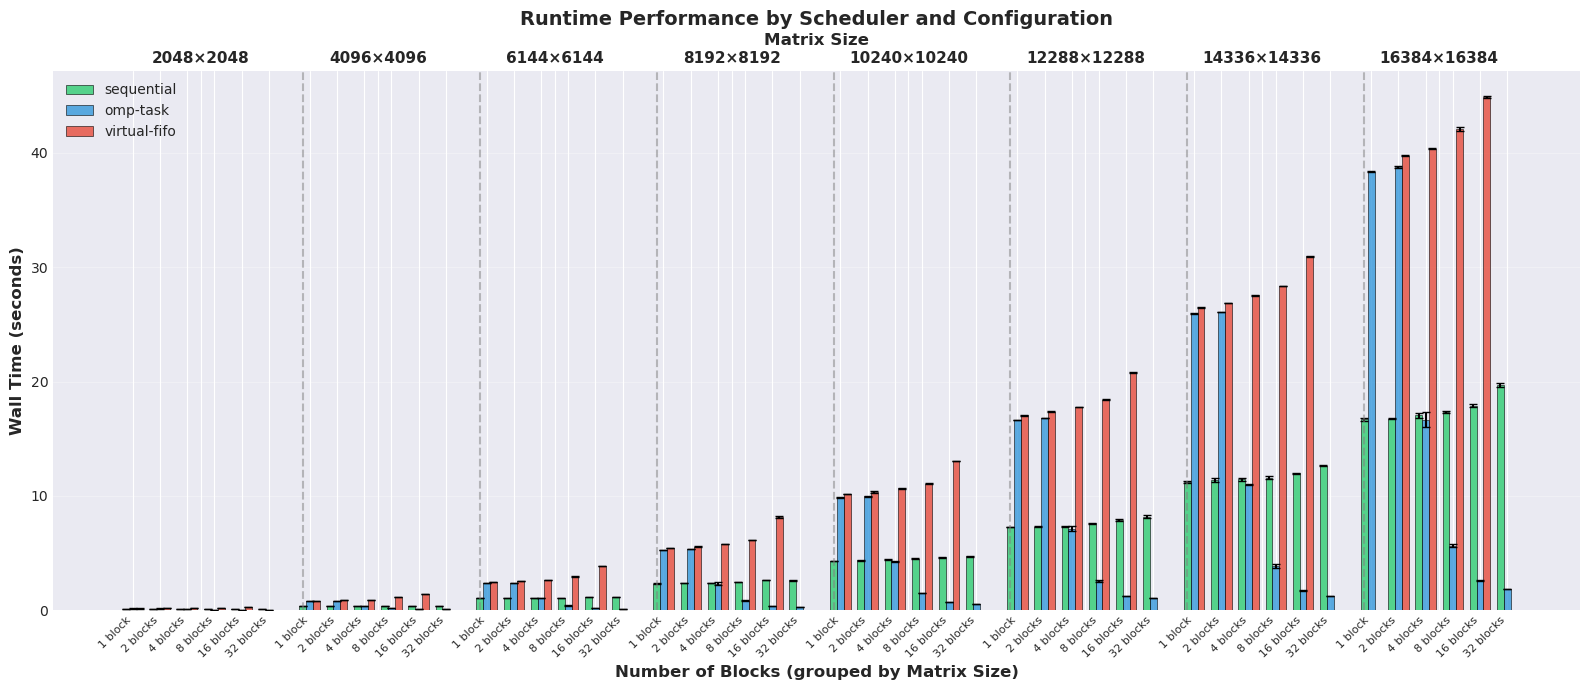

Saved: runtime_performance.png


In [30]:
# Runtime Performance - Wall Time
# Sort by matrix_size first, then num_blocks
runtime_stats_sorted = results.groupby(['matrix_size', 'num_blocks', 'scheduler']).agg({
    'wall_time': ['mean', 'std']
}).reset_index()

# Flatten column names
runtime_stats_sorted.columns = ['matrix_size', 'num_blocks', 'scheduler', 'wall_time_mean', 'wall_time_std']
runtime_stats_sorted = runtime_stats_sorted.sort_values(['matrix_size', 'num_blocks'])

# Pivot for plotting
pivot_wall = runtime_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='wall_time_mean')
pivot_wall_std = runtime_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='wall_time_std')

# Use scheduler_order
pivot_wall = pivot_wall[scheduler_order]
pivot_wall_std = pivot_wall_std[scheduler_order]

# Calculate positions with spacing between matrix size groups
matrix_sizes_numeric = sorted(pivot_wall.index.get_level_values(0).unique())
x_positions = []
tick_positions = []
tick_labels = []
matrix_group_centers = []

current_x = 0
width = 0.25
group_spacing = 0.5

for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    matrix_data = pivot_wall.loc[matrix_size]
    group_start = current_x
    
    for config_idx, num_blocks in enumerate(matrix_data.index):
        x_positions.append(current_x)
        tick_positions.append(current_x)
        tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        current_x += 1
    
    group_end = current_x - 1
    matrix_group_centers.append((group_start + group_end) / 2)
    current_x += group_spacing

x_positions = np.array(x_positions)

# Flatten data for plotting
flat_wall = pivot_wall.values
flat_wall_std = pivot_wall_std.values

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot bars with error bars for each scheduler
for i, scheduler in enumerate(scheduler_order):
    offset = (i - 1) * width
    color = scheduler_colors.get(scheduler, f'C{i}')
    
    bars = ax.bar(x_positions + offset, flat_wall[:, i], width,
                  yerr=flat_wall_std[:, i],
                  label=scheduler, color=color, alpha=0.8, 
                  capsize=3, edgecolor='black', linewidth=0.5)

# Add vertical separators between matrix size groups
current_x = 0
for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    if matrix_idx > 0:
        separator_x = current_x - group_spacing / 2
        ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    
    matrix_data = pivot_wall.loc[matrix_size]
    current_x += len(matrix_data) + group_spacing

ax.set_ylabel('Wall Time (seconds)', fontweight='bold', fontsize=12)
ax.set_xlabel('Number of Blocks (grouped by Matrix Size)', fontweight='bold', fontsize=12)
ax.set_title('Runtime Performance by Scheduler and Configuration', fontweight='bold', fontsize=14)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=8, rotation=45, ha='right')

# Add matrix size labels as secondary x-axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(matrix_group_centers)
ax2.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], fontweight='bold', fontsize=11)
ax2.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', which='both', length=0)

ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('runtime_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: runtime_performance.png")

## Runtime Performance - Relative to Sequential (% Change)

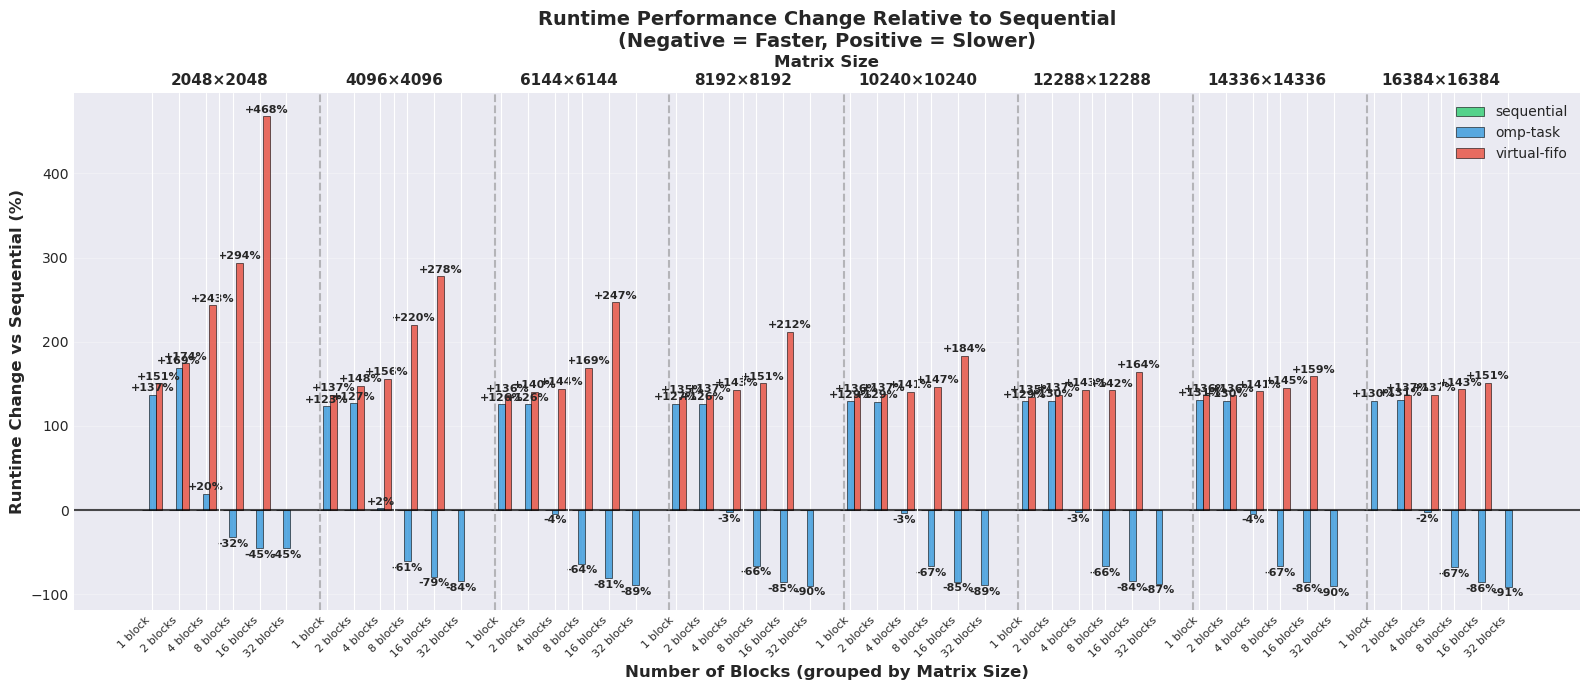

Saved: runtime_performance_relative.png


In [32]:
# Runtime Performance - Percentage Change Relative to Sequential
# Calculate percentage change for each configuration
runtime_relative = runtime_stats_sorted.copy()

# For each matrix_size and num_blocks combination, calculate % change vs sequential
relative_data = []
for (matrix_size, num_blocks), group in runtime_relative.groupby(['matrix_size', 'num_blocks']):
    seq_data = group[group['scheduler'] == 'sequential']
    if len(seq_data) == 0:
        continue
    
    seq_time = seq_data['wall_time_mean'].values[0]
    
    for _, row in group.iterrows():
        pct_change = ((row['wall_time_mean'] - seq_time) / seq_time) * 100
        relative_data.append({
            'matrix_size': matrix_size,
            'num_blocks': num_blocks,
            'scheduler': row['scheduler'],
            'pct_change': pct_change,
            'seq_baseline': seq_time
        })

runtime_relative_df = pd.DataFrame(relative_data)
runtime_relative_df = runtime_relative_df.sort_values(['matrix_size', 'num_blocks'])

# Pivot for plotting
pivot_pct = runtime_relative_df.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='pct_change')
pivot_pct = pivot_pct[scheduler_order]

# Calculate positions (same as absolute graph)
matrix_sizes_numeric = sorted(pivot_pct.index.get_level_values(0).unique())
x_positions = []
tick_positions = []
tick_labels = []
matrix_group_centers = []

current_x = 0
width = 0.25
group_spacing = 0.5

for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    matrix_data = pivot_pct.loc[matrix_size]
    group_start = current_x
    
    for config_idx, num_blocks in enumerate(matrix_data.index):
        x_positions.append(current_x)
        tick_positions.append(current_x)
        tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        current_x += 1
    
    group_end = current_x - 1
    matrix_group_centers.append((group_start + group_end) / 2)
    current_x += group_spacing

x_positions = np.array(x_positions)

# Flatten data for plotting
flat_pct = pivot_pct.values

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot bars for each scheduler
for i, scheduler in enumerate(scheduler_order):
    offset = (i - 1) * width
    color = scheduler_colors.get(scheduler, f'C{i}')
    
    values = flat_pct[:, i]
    valid_mask = ~np.isnan(values)
    
    if valid_mask.any():
        valid_x = (x_positions + offset)[valid_mask]
        valid_values = values[valid_mask]
        
        bars = ax.bar(valid_x, valid_values, width,
                      label=scheduler, color=color, alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for xp, val in zip(valid_x, valid_values):
            if abs(val) > 0.5:  # Only show label if significant
                y_pos = val + (2 if val >= 0 else -2)
                va = 'bottom' if val >= 0 else 'top'
                ax.text(xp, y_pos, f'{val:+.0f}%', ha='center', va=va, fontsize=8, fontweight='bold')

# Add reference line at 0%
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)

# Add vertical separators between matrix size groups
current_x = 0
for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    if matrix_idx > 0:
        separator_x = current_x - group_spacing / 2
        ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    
    matrix_data = pivot_pct.loc[matrix_size]
    current_x += len(matrix_data) + group_spacing

ax.set_ylabel('Runtime Change vs Sequential (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Number of Blocks (grouped by Matrix Size)', fontweight='bold', fontsize=12)
ax.set_title('Runtime Performance Change Relative to Sequential\n(Negative = Faster, Positive = Slower)', fontweight='bold', fontsize=14)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=8, rotation=45, ha='right')

# Add matrix size labels as secondary x-axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(matrix_group_centers)
ax2.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], fontweight='bold', fontsize=11)
ax2.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', which='both', length=0)

ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('runtime_performance_relative.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: runtime_performance_relative.png")

## Memory Usage (Max RSS)

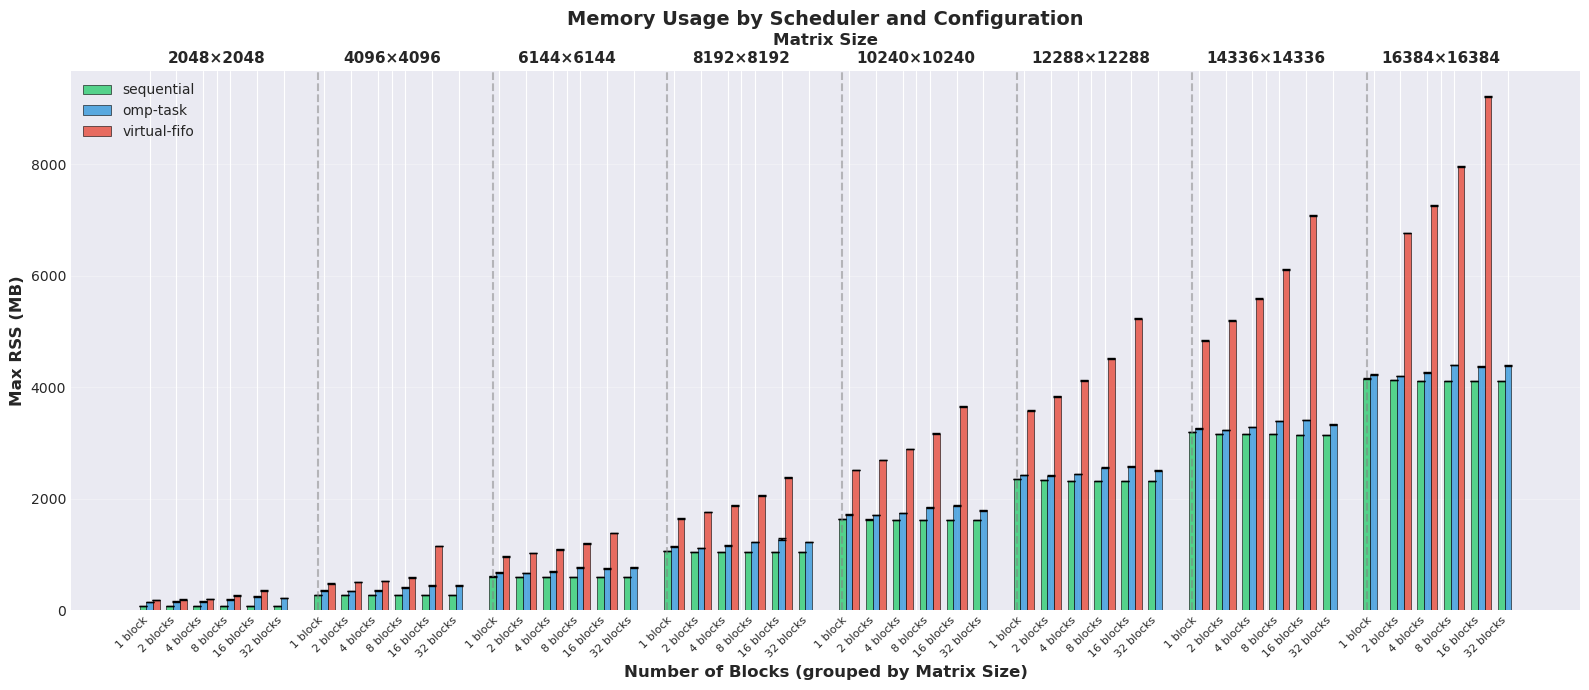

Saved: memory_usage.png


In [31]:
# Memory Usage (Max RSS)
# Sort by matrix_size first, then num_blocks
memory_stats_sorted = results.groupby(['matrix_size', 'num_blocks', 'scheduler']).agg({
    'max_rss_kb': ['mean', 'std']
}).reset_index()

# Flatten column names
memory_stats_sorted.columns = ['matrix_size', 'num_blocks', 'scheduler', 'max_rss_kb_mean', 'max_rss_kb_std']
memory_stats_sorted = memory_stats_sorted.sort_values(['matrix_size', 'num_blocks'])

# Pivot for plotting (convert to MB)
pivot_rss = memory_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='max_rss_kb_mean') / 1024
pivot_rss_std = memory_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='max_rss_kb_std') / 1024

# Use scheduler_order
pivot_rss = pivot_rss[scheduler_order]
pivot_rss_std = pivot_rss_std[scheduler_order]

# Calculate positions (reuse same structure as runtime)
matrix_sizes_numeric = sorted(pivot_rss.index.get_level_values(0).unique())
x_positions = []
tick_positions = []
tick_labels = []
matrix_group_centers = []

current_x = 0
width = 0.25
group_spacing = 0.5

for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    matrix_data = pivot_rss.loc[matrix_size]
    group_start = current_x
    
    for config_idx, num_blocks in enumerate(matrix_data.index):
        x_positions.append(current_x)
        tick_positions.append(current_x)
        tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        current_x += 1
    
    group_end = current_x - 1
    matrix_group_centers.append((group_start + group_end) / 2)
    current_x += group_spacing

x_positions = np.array(x_positions)

# Flatten data for plotting
flat_rss = pivot_rss.values
flat_rss_std = pivot_rss_std.values

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot bars with error bars for each scheduler
for i, scheduler in enumerate(scheduler_order):
    offset = (i - 1) * width
    color = scheduler_colors.get(scheduler, f'C{i}')
    
    bars = ax.bar(x_positions + offset, flat_rss[:, i], width,
                  yerr=flat_rss_std[:, i],
                  label=scheduler, color=color, alpha=0.8,
                  capsize=3, edgecolor='black', linewidth=0.5)

# Add vertical separators between matrix size groups
current_x = 0
for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    if matrix_idx > 0:
        separator_x = current_x - group_spacing / 2
        ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    
    matrix_data = pivot_rss.loc[matrix_size]
    current_x += len(matrix_data) + group_spacing

ax.set_ylabel('Max RSS (MB)', fontweight='bold', fontsize=12)
ax.set_xlabel('Number of Blocks (grouped by Matrix Size)', fontweight='bold', fontsize=12)
ax.set_title('Memory Usage by Scheduler and Configuration', fontweight='bold', fontsize=14)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=8, rotation=45, ha='right')

# Add matrix size labels as secondary x-axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(matrix_group_centers)
ax2.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], fontweight='bold', fontsize=11)
ax2.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', which='both', length=0)

ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('memory_usage.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: memory_usage.png")

## Memory Usage - Relative to Sequential (% Change)

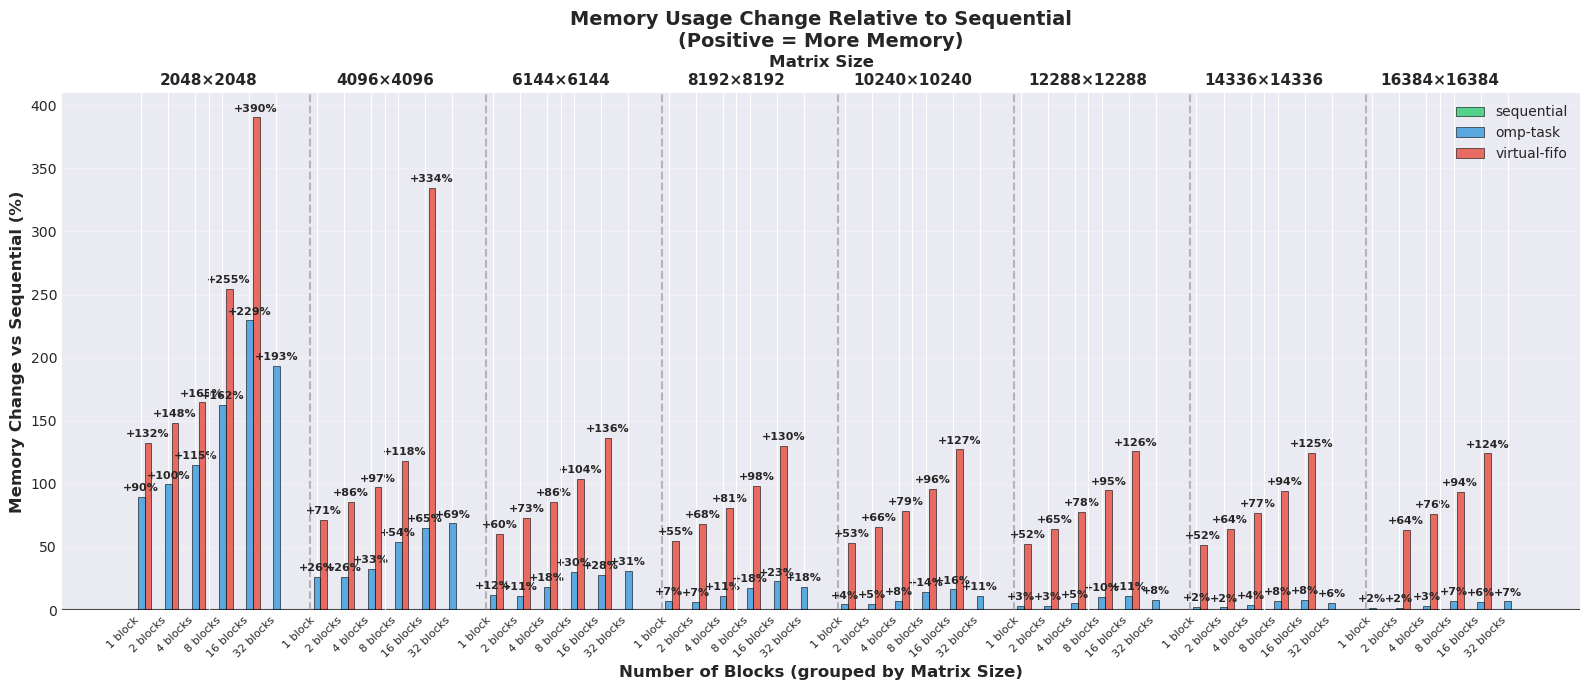

Saved: memory_usage_relative.png


In [33]:
# Memory Usage - Percentage Change Relative to Sequential
# Calculate percentage change for each configuration
memory_relative = memory_stats_sorted.copy()

# For each matrix_size and num_blocks combination, calculate % change vs sequential
relative_data = []
for (matrix_size, num_blocks), group in memory_relative.groupby(['matrix_size', 'num_blocks']):
    seq_data = group[group['scheduler'] == 'sequential']
    if len(seq_data) == 0:
        continue
    
    seq_memory = seq_data['max_rss_kb_mean'].values[0]
    
    for _, row in group.iterrows():
        pct_change = ((row['max_rss_kb_mean'] - seq_memory) / seq_memory) * 100
        relative_data.append({
            'matrix_size': matrix_size,
            'num_blocks': num_blocks,
            'scheduler': row['scheduler'],
            'pct_change': pct_change,
            'seq_baseline': seq_memory
        })

memory_relative_df = pd.DataFrame(relative_data)
memory_relative_df = memory_relative_df.sort_values(['matrix_size', 'num_blocks'])

# Pivot for plotting
pivot_pct = memory_relative_df.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='pct_change')
pivot_pct = pivot_pct[scheduler_order]

# Calculate positions (same as absolute graph)
matrix_sizes_numeric = sorted(pivot_pct.index.get_level_values(0).unique())
x_positions = []
tick_positions = []
tick_labels = []
matrix_group_centers = []

current_x = 0
width = 0.25
group_spacing = 0.5

for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    matrix_data = pivot_pct.loc[matrix_size]
    group_start = current_x
    
    for config_idx, num_blocks in enumerate(matrix_data.index):
        x_positions.append(current_x)
        tick_positions.append(current_x)
        tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        current_x += 1
    
    group_end = current_x - 1
    matrix_group_centers.append((group_start + group_end) / 2)
    current_x += group_spacing

x_positions = np.array(x_positions)

# Flatten data for plotting
flat_pct = pivot_pct.values

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot bars for each scheduler
for i, scheduler in enumerate(scheduler_order):
    offset = (i - 1) * width
    color = scheduler_colors.get(scheduler, f'C{i}')
    
    values = flat_pct[:, i]
    valid_mask = ~np.isnan(values)
    
    if valid_mask.any():
        valid_x = (x_positions + offset)[valid_mask]
        valid_values = values[valid_mask]
        
        bars = ax.bar(valid_x, valid_values, width,
                      label=scheduler, color=color, alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for xp, val in zip(valid_x, valid_values):
            if abs(val) > 1:  # Only show label if significant
                y_pos = val + (3 if val >= 0 else -3)
                va = 'bottom' if val >= 0 else 'top'
                ax.text(xp, y_pos, f'{val:+.0f}%', ha='center', va=va, fontsize=8, fontweight='bold')

# Add reference line at 0%
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)

# Add vertical separators between matrix size groups
current_x = 0
for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    if matrix_idx > 0:
        separator_x = current_x - group_spacing / 2
        ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    
    matrix_data = pivot_pct.loc[matrix_size]
    current_x += len(matrix_data) + group_spacing

ax.set_ylabel('Memory Change vs Sequential (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Number of Blocks (grouped by Matrix Size)', fontweight='bold', fontsize=12)
ax.set_title('Memory Usage Change Relative to Sequential\n(Positive = More Memory)', fontweight='bold', fontsize=14)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=8, rotation=45, ha='right')

# Add matrix size labels as secondary x-axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(matrix_group_centers)
ax2.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], fontweight='bold', fontsize=11)
ax2.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', which='both', length=0)

ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('memory_usage_relative.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: memory_usage_relative.png")

## Summary Statistics

In [ ]:
print("=" * 80)
print("BINARY SIZE SUMMARY (KB)")
print("=" * 80)

# Build aggregation dict based on available columns
agg_dict = {
    'total_size': ['mean', 'min', 'max'],
    'text_size': ['mean', 'min', 'max']
}
if has_compile_time:
    agg_dict['compile_time'] = ['mean', 'min', 'max']

summary = build_metrics.groupby('scheduler').agg(agg_dict) / 1024
if has_compile_time:
    summary['compile_time'] *= 1024  # Don't convert compile time
print(summary.round(2))

print("\n" + "=" * 80)
print("RUNTIME PERFORMANCE SUMMARY")
print("=" * 80)
perf_summary = results.groupby('scheduler').agg({
    'wall_time': ['mean', 'std', 'min', 'max'],
    'max_rss_kb': ['mean', 'std', 'min', 'max']
})
print(perf_summary.round(4))

print("\n" + "=" * 80)
print("OVERHEAD ANALYSIS (vs sequential)")
print("=" * 80)
seq_size = build_metrics[build_metrics['scheduler'] == 'sequential']['total_size'].mean()
for scheduler in ['omp-task', 'virtual-fifo']:
    sched_size = build_metrics[build_metrics['scheduler'] == scheduler]['total_size'].mean()
    overhead = ((sched_size / seq_size) - 1) * 100
    print(f"{scheduler:20s} binary size overhead: {overhead:6.1f}% ({sched_size/1024:.1f} KB vs {seq_size/1024:.1f} KB)")

if has_compile_time:
    print()
    seq_compile = build_metrics[build_metrics['scheduler'] == 'sequential']['compile_time'].mean()
    for scheduler in ['omp-task', 'virtual-fifo']:
        sched_compile = build_metrics[build_metrics['scheduler'] == scheduler]['compile_time'].mean()
        overhead = ((sched_compile / seq_compile) - 1) * 100
        print(f"{scheduler:20s} compile time overhead: {overhead:6.1f}% ({sched_compile:.2f}s vs {seq_compile:.2f}s)")
else:
    print("\nCompilation time overhead analysis not available (no compile_time data)")

BINARY SIZE SUMMARY (KB)
             total_size                  text_size               
                   mean     min      max      mean    min     max
scheduler                                                        
omp-task          43.75   35.20    62.64      7.14   3.35   20.93
sequential        43.83   35.30    62.59      7.15   3.35   20.90
virtual-fifo    1897.89  712.24  5637.75     41.10  16.07  119.36

RUNTIME PERFORMANCE SUMMARY
             wall_time                              max_rss_kb                \
                  mean      std     min      max          mean           std   
scheduler                                                                      
omp-task        5.4590   9.2148  0.0271  38.8802  1.831368e+06  1.416063e+06   
sequential      5.6814   5.8591  0.0503  19.9046  1.697081e+06  1.387799e+06   
virtual-fifo   13.3929  13.5248  0.1202  44.9524  3.123828e+06  2.557465e+06   

                               
                 min      max  
sched